In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

import pickle
import os

In [17]:
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns=100
plt.style.use('ggplot')
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.2; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/75.0.3770.100 Safari/537.36'}

In [18]:
standard_stats=pd.read_csv(r"C:\Users\berid\python\fbref_data\standard_stats.csv")
goalkeeping=pd.read_csv(r"C:\Users\berid\python\fbref_data\goalkeeping.csv")
advanced_goalkeeping=pd.read_csv(r"C:\Users\berid\python\fbref_data\advanced_goalkeeping.csv")
shooting=pd.read_csv(r"C:\Users\berid\python\fbref_data\shooting.csv")
passing=pd.read_csv(r"C:\Users\berid\python\fbref_data\passing.csv")
goal_and_shot_creation=pd.read_csv(r"C:\Users\berid\python\fbref_data\goal_and_shot_creation.csv")
defensive_actions=pd.read_csv(r"C:\Users\berid\python\fbref_data\defensive_actions.csv")
possession=pd.read_csv(r"C:\Users\berid\python\fbref_data\possession.csv")
playing_time=pd.read_csv(r"C:\Users\berid\python\fbref_data\playing_time.csv")
miscellaneous_stats=pd.read_csv(r"C:\Users\berid\python\fbref_data\miscellaneous_stats.csv")

In [19]:
standard_stats=standard_stats.query('`Unnamed: 0_level_0_Player`.isin(["Squad Total","Opponent Total"])==False')
goalkeeping=goalkeeping.query('`Unnamed: 0_level_0_Player`.isin(["Squad Total","Opponent Total"])==False')
advanced_goalkeeping=advanced_goalkeeping.query('`Unnamed: 0_level_0_Player`.isin(["Squad Total","Opponent Total"])==False')
shooting=shooting.query('`Unnamed: 0_level_0_Player`.isin(["Squad Total","Opponent Total"])==False')
passing=passing.query('`Unnamed: 0_level_0_Player`.isin(["Squad Total","Opponent Total"])==False')
goal_and_shot_creation=goal_and_shot_creation.query('`Unnamed: 0_level_0_Player`.isin(["Squad Total","Opponent Total"])==False')
defensive_actions=defensive_actions.query('`Unnamed: 0_level_0_Player`.isin(["Squad Total","Opponent Total"])==False')
possession=possession.query('`Unnamed: 0_level_0_Player`.isin(["Squad Total","Opponent Total"])==False')
playing_time=playing_time.query('`Unnamed: 0_level_0_Player`.isin(["Squad Total","Opponent Total"])==False')
miscellaneous_stats=miscellaneous_stats.query('`Unnamed: 0_level_0_Player`.isin(["Squad Total","Opponent Total"])==False')

In [20]:
grouped_ss=standard_stats.groupby(['Season','League','Team'])['Performance_Gls'].sum().reset_index()
grouped_gk=goalkeeping.groupby(['Season','League','Team'])['Performance_GA'].sum().reset_index()

merged_ss_gk=pd.merge(grouped_ss,grouped_gk,on=['Season','League','Team'])
merged_ss_gk.columns=['Season','League','Team','Scored','Accepted']

matches=standard_stats.drop_duplicates(subset=standard_stats.columns[[0,1,2]]).groupby(['Season','League'])['Team'].count().reset_index()
matches=matches.rename(columns={'Team':'Matches'})
matches['Matches']=(matches['Matches']-1)*2

merged_ss_gk=pd.merge(merged_ss_gk,matches,on=['Season','League'])
merged_ss_gk['AVG_Scored_per_Match']=merged_ss_gk['Scored']/merged_ss_gk['Matches']
merged_ss_gk['AVG_Accepted_per_Match']=merged_ss_gk['Accepted']/merged_ss_gk['Matches']

In [21]:
data=standard_stats[['Season','League','Team']].drop_duplicates(keep='first')
champions=data.groupby(['Season','League']).head(1)
champions['Champion']='Champion'

In [22]:
merged_ss_gk=pd.merge(merged_ss_gk,champions,on=['Season','League','Team'],how='left')
merged_ss_gk['Champion']=merged_ss_gk['Champion'].fillna('Non Champion')

In [23]:
merged_ss_gk=merged_ss_gk.query('AVG_Scored_per_Match>0 and AVG_Accepted_per_Match>0')

In [24]:
data['Rank']=data.groupby(['Season','League'])['Team'].cumcount()+1

merged_ss_gk=pd.merge(merged_ss_gk,data,on=['Season','League','Team'])

In [25]:
merged_ss_gk

,Season,League,Team,Scored,Accepted,Matches,AVG_Scored_per_Match,AVG_Accepted_per_Match,Champion,Rank
0,2000-2001,Bundesliga,1860 Munich,40.0,55.0,34,1.176471,1.617647,Non Champion,11
1,2000-2001,Bundesliga,Bayern Munich,62.0,37.0,34,1.823529,1.088235,Champion,1
2,2000-2001,Bundesliga,Bochum,30.0,67.0,34,0.882353,1.970588,Non Champion,18
3,2000-2001,Bundesliga,Dortmund,59.0,42.0,34,1.735294,1.235294,Non Champion,3
4,2000-2001,Bundesliga,Eint Frankfurt,40.0,68.0,34,1.176471,2.000000,Non Champion,17
...,...,...,...,...,...,...,...,...,...,...
3013,2022-2023,SeriaA,Sampdoria,13.0,43.0,38,0.342105,1.131579,Non Champion,20
3014,2022-2023,SeriaA,Sassuolo,33.0,40.0,38,0.868421,1.052632,Non Champion,13
3015,2022-2023,SeriaA,Spezia,21.0,42.0,38,0.552632,1.105263,Non Champion,17
3016,2022-2023,SeriaA,Torino,29.0,29.0,38,0.763158,0.763158,Non Champion,8


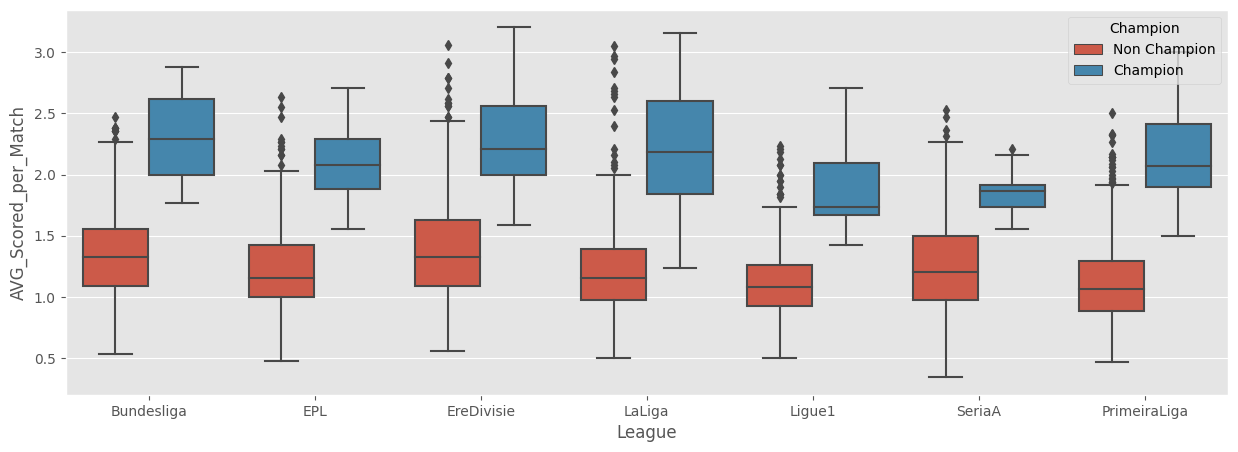

In [26]:
plt.figure(figsize=(15,5))
sns.boxplot(merged_ss_gk,x='League',y='AVG_Scored_per_Match',hue='Champion')
plt.show()

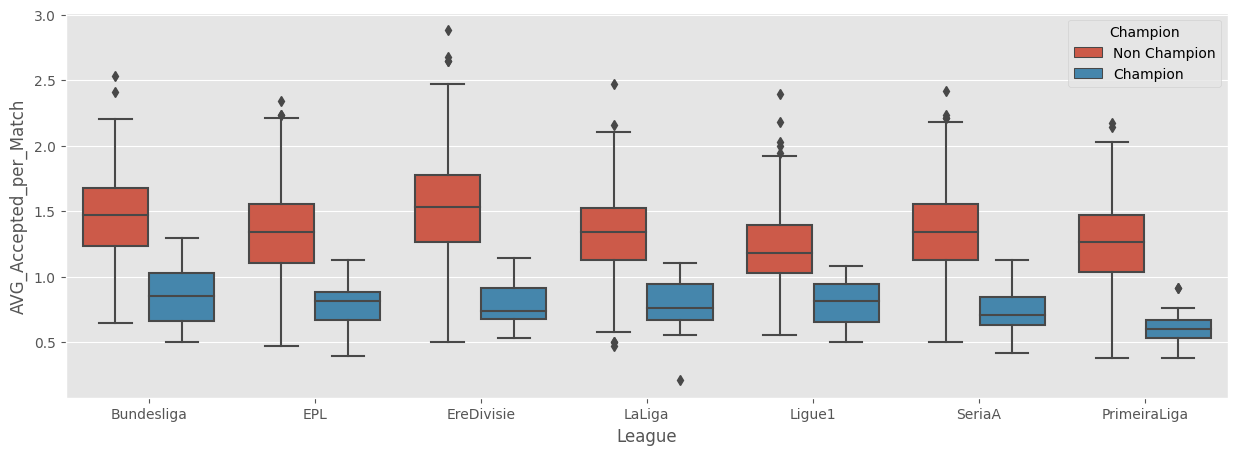

In [27]:
plt.figure(figsize=(15,5))
sns.boxplot(merged_ss_gk,x='League',y='AVG_Accepted_per_Match',hue='Champion')
plt.show()

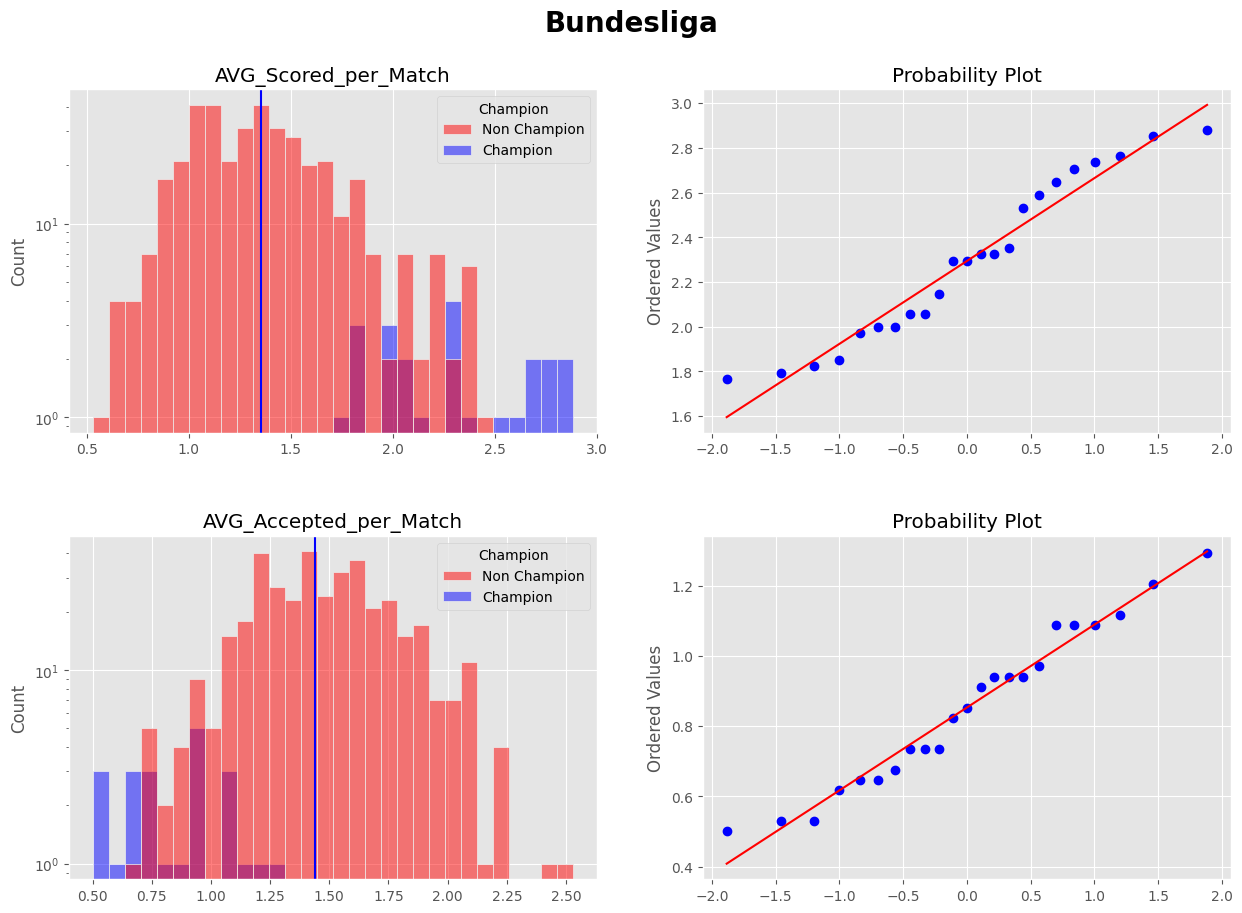

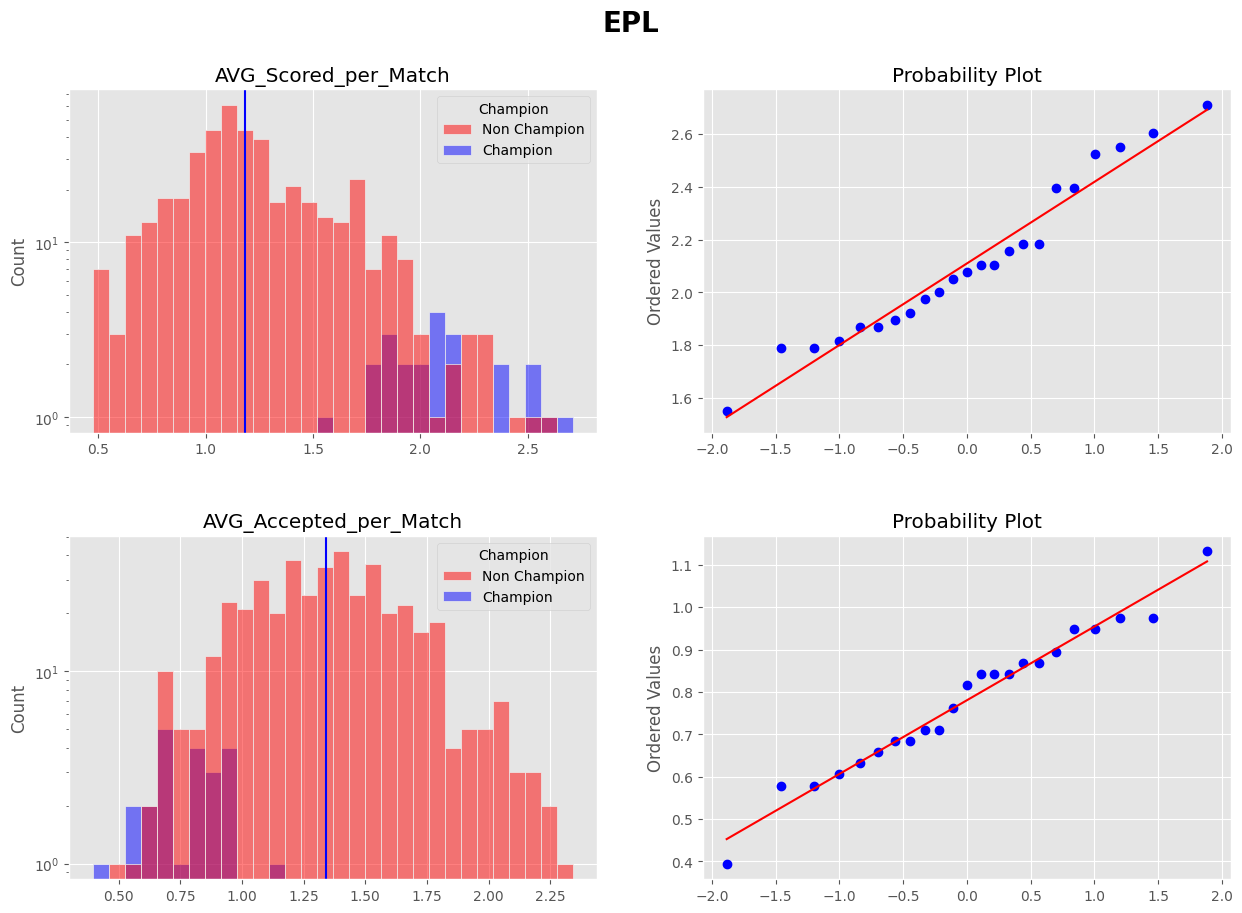

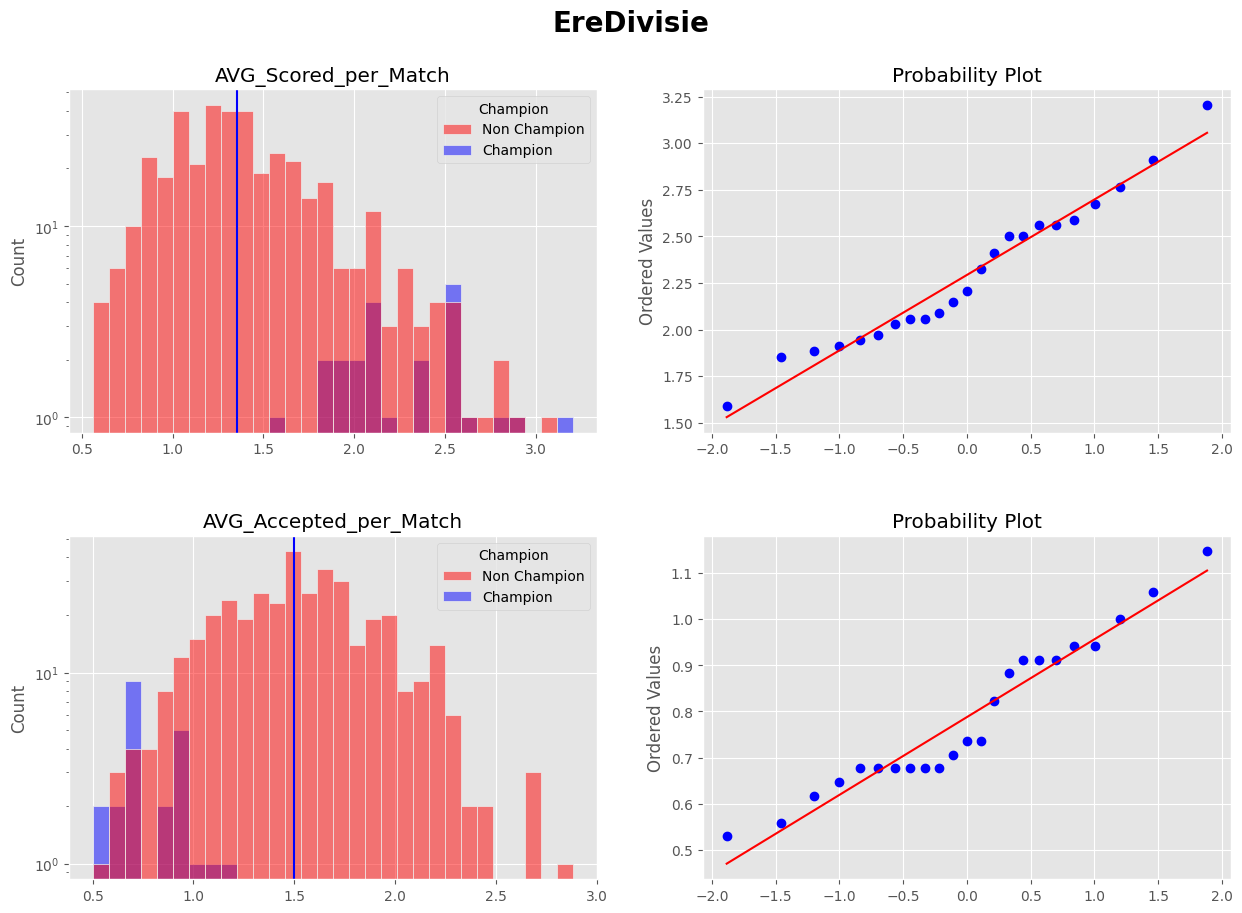

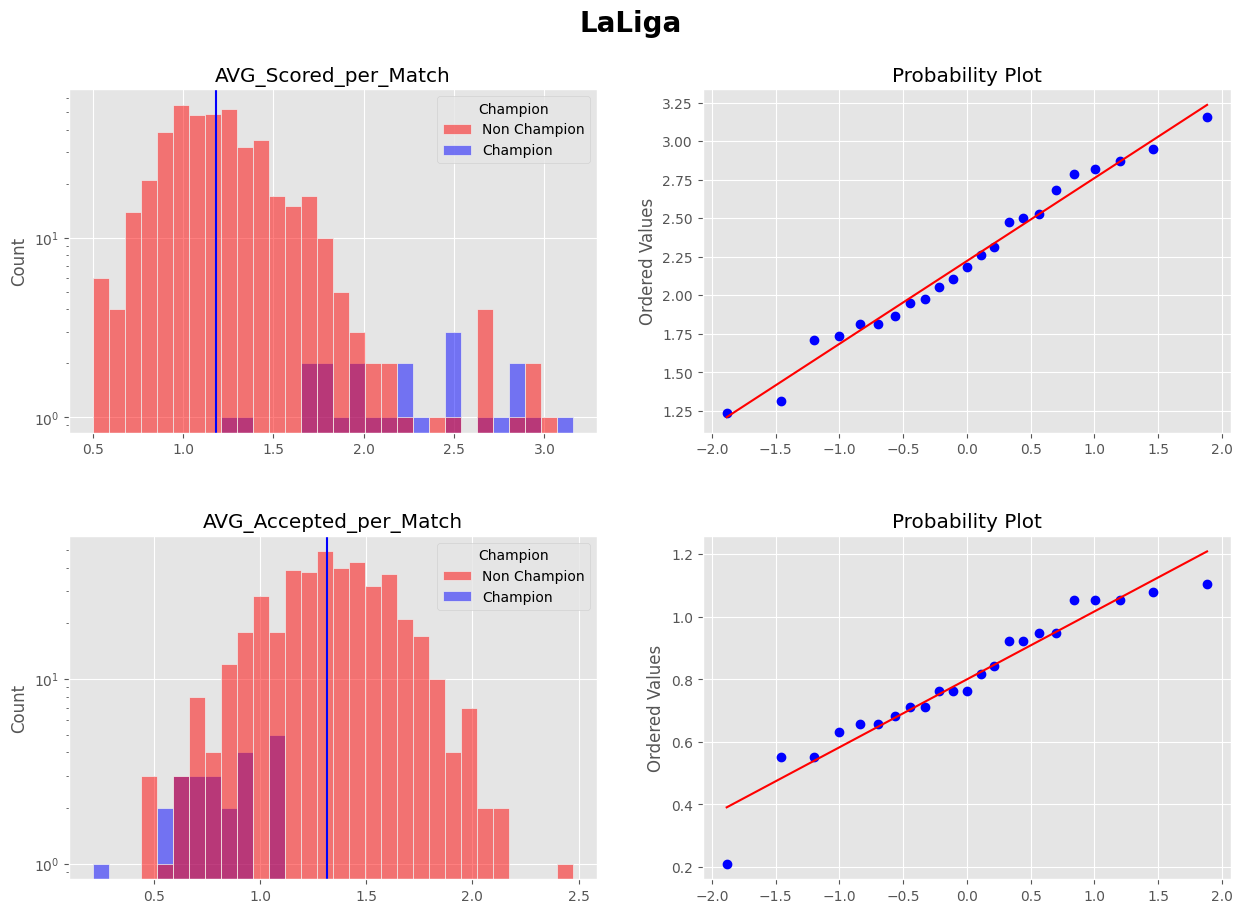

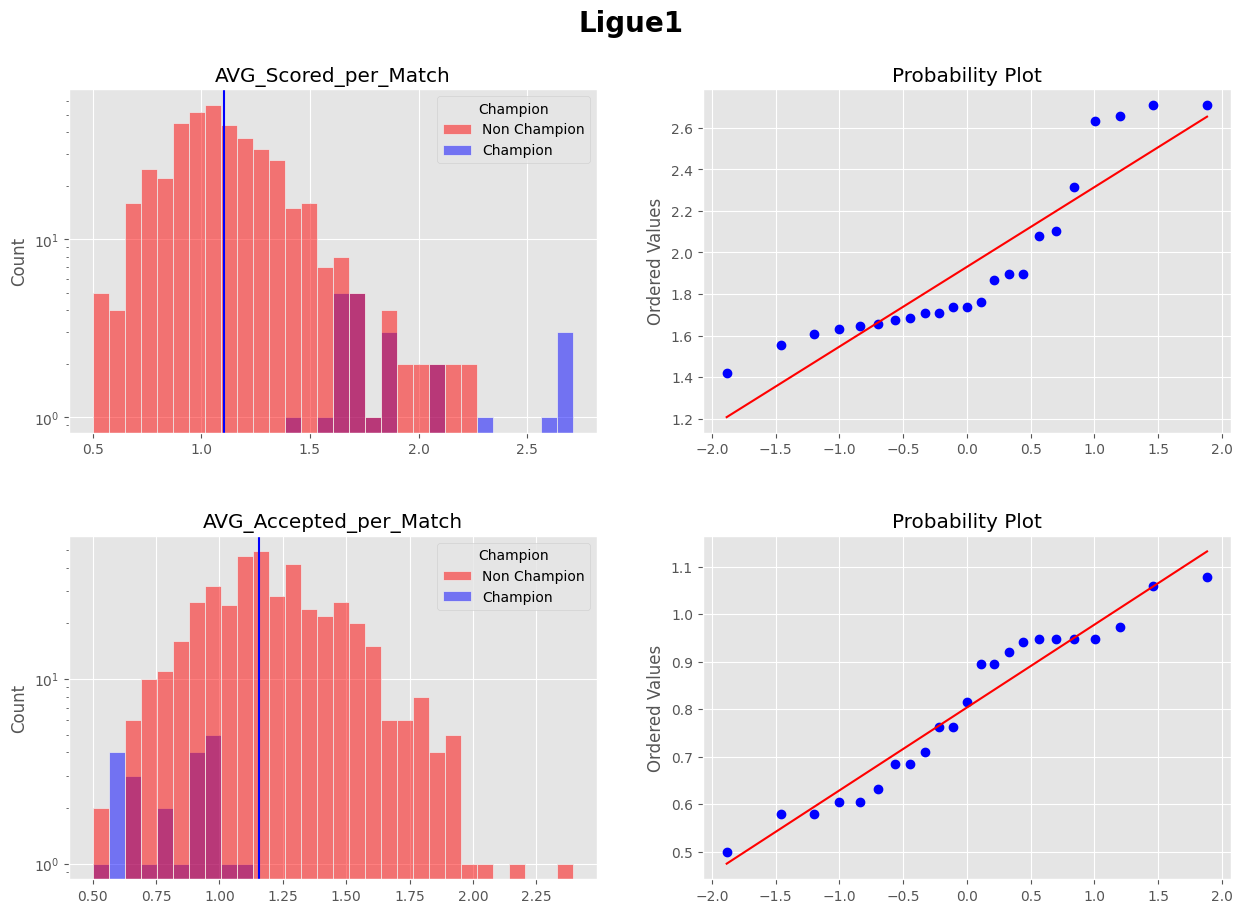

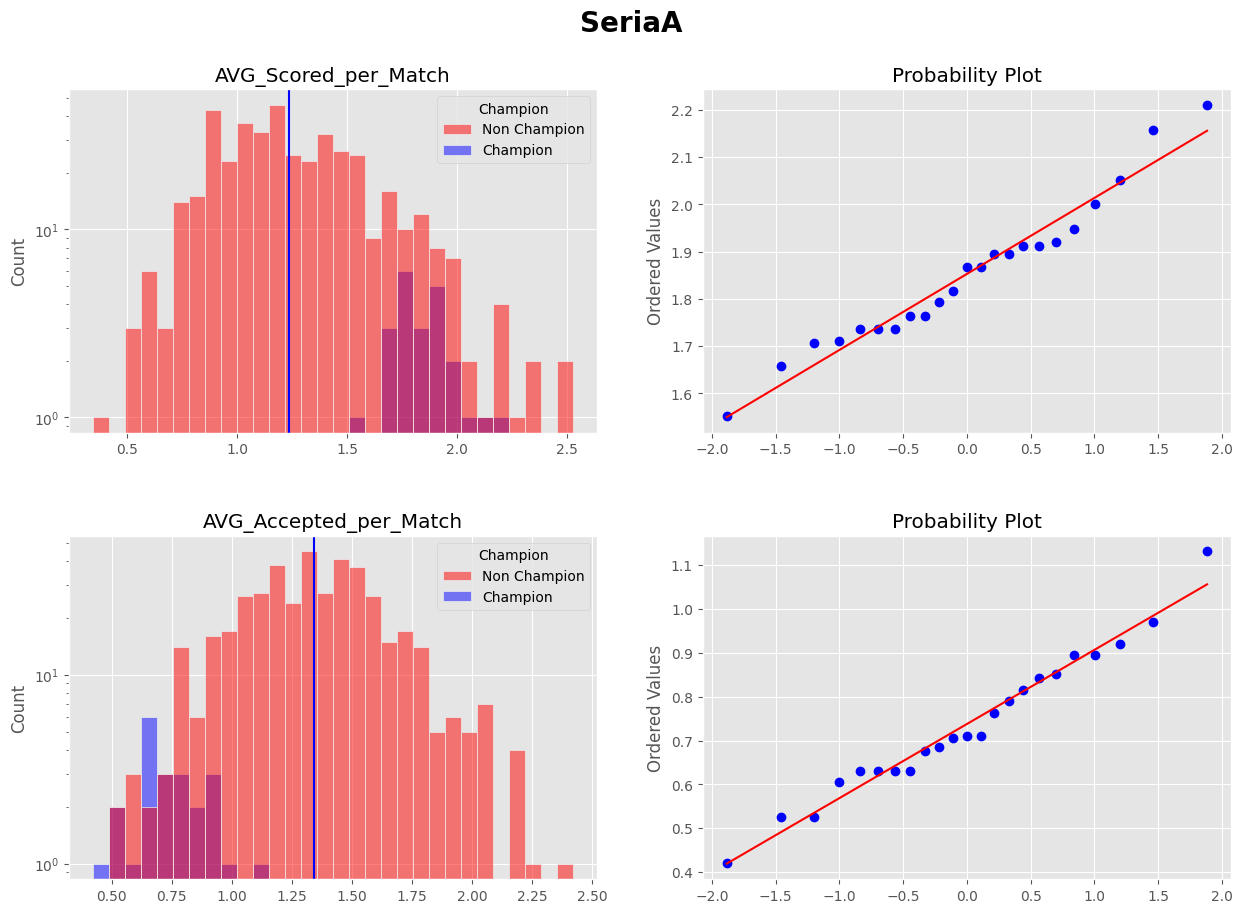

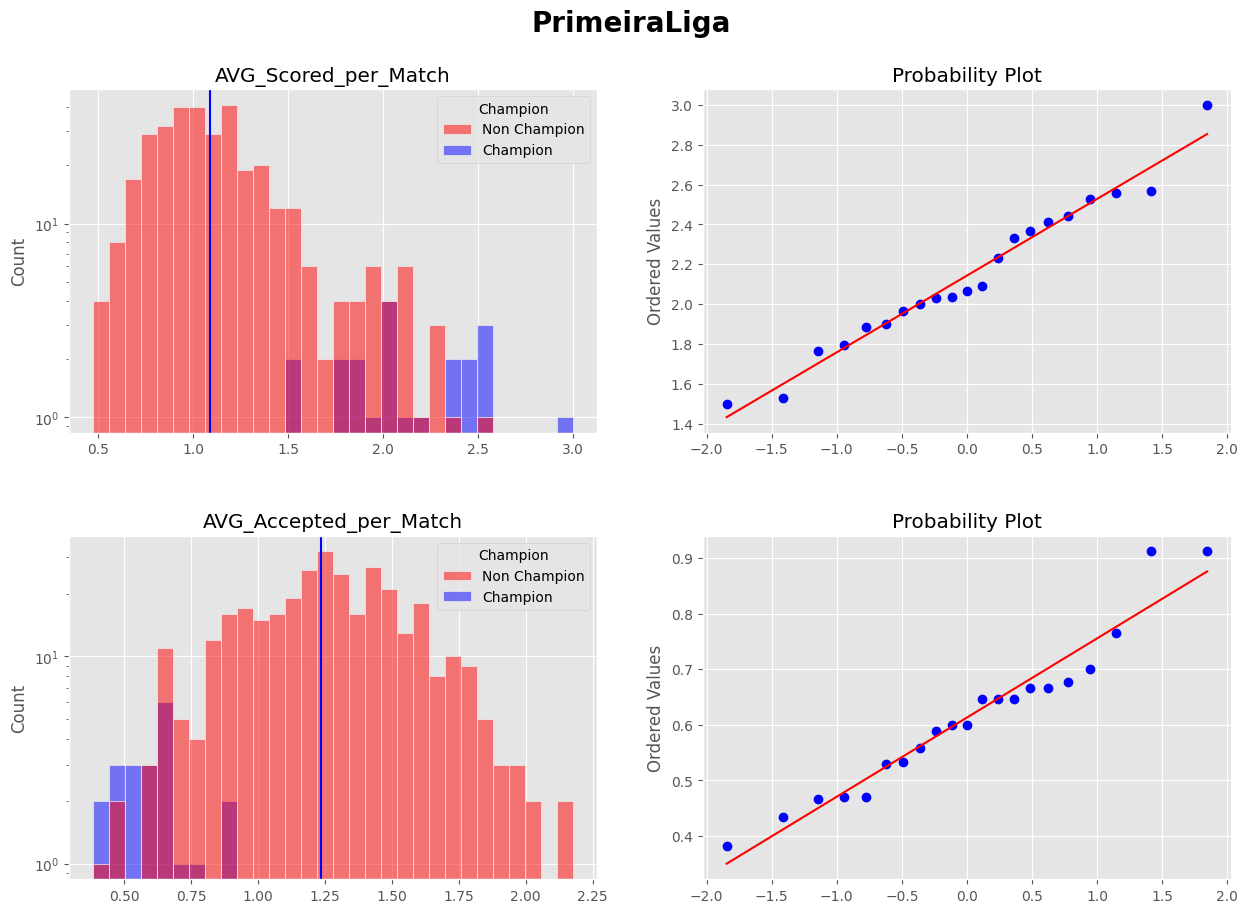

In [28]:
for league in merged_ss_gk['League'].unique():
    
    fig,((ax1,ax2),(ax3,ax4))=plt.subplots(2,2,figsize=(15,10))
    filt=merged_ss_gk.query('League==@league')
    
    sns.histplot(filt,x='AVG_Scored_per_Match',bins=30,ax=ax1,hue='Champion',palette=['red','blue'])
    ax1.axvline(filt['AVG_Scored_per_Match'].median(),color='b',label='Median Value')
    ax1.set_title('AVG_Scored_per_Match')
    ax1.set_xlabel('')
    ax1.set_yscale('log')
    
    stats.probplot(filt.query('Champion=="Champion"')['AVG_Scored_per_Match'],dist='norm',plot=ax2)
    stats.probplot(filt.query('Champion=="Not Champion"')['AVG_Scored_per_Match'],dist='norm',plot=ax2)
    ax2.set_xlabel('')
    
    sns.histplot(filt,x='AVG_Accepted_per_Match',bins=30,ax=ax3,hue='Champion',palette=['red','blue'])
    ax3.axvline(filt['AVG_Accepted_per_Match'].median(),color='b',label='Median Value')
    ax3.set_title('AVG_Accepted_per_Match')
    ax3.set_xlabel('')
    ax3.set_yscale('log')
    
    stats.probplot(filt.query('Champion=="Champion"')['AVG_Accepted_per_Match'],dist='norm',plot=ax4)
    stats.probplot(filt.query('Champion=="Not Champion"')['AVG_Accepted_per_Match'],dist='norm',plot=ax4)
    ax4.set_xlabel('')
    
    plt.suptitle(league,size=20,fontweight='bold')
    plt.subplots_adjust(hspace=0.3,top=0.90)
    plt.show()
    print('\n\n\n\n')

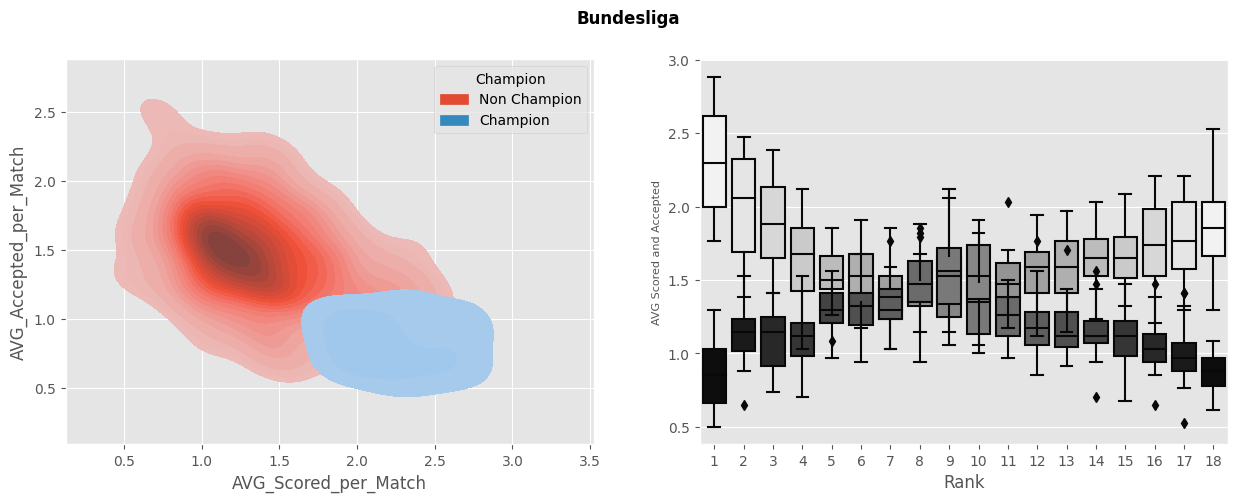

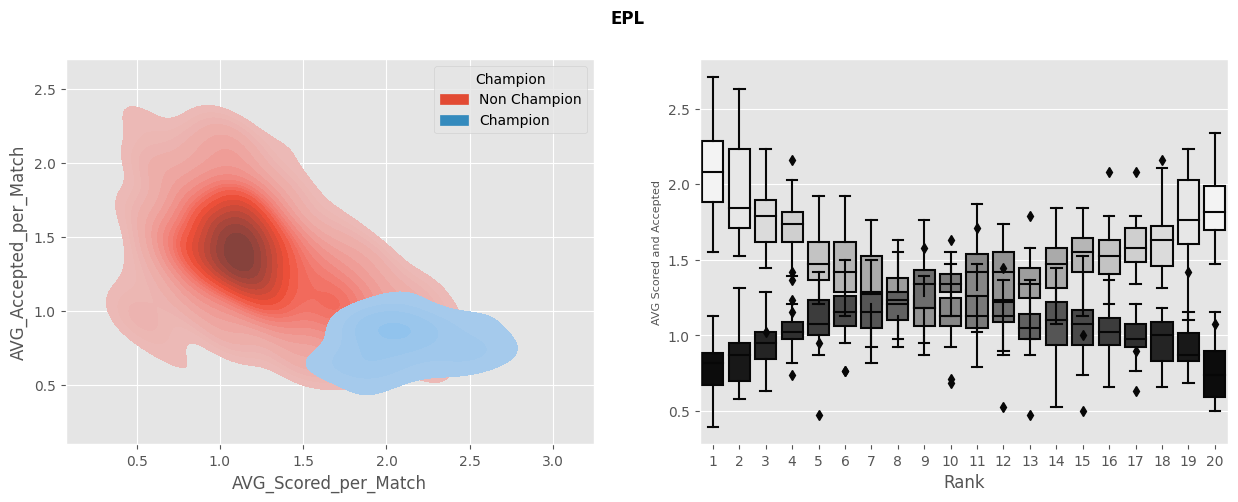

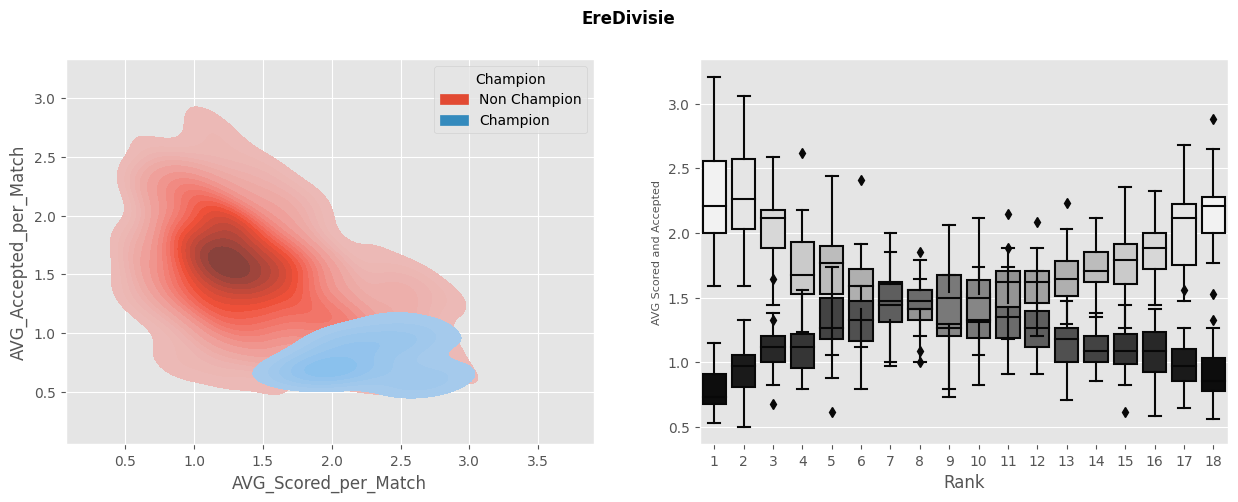

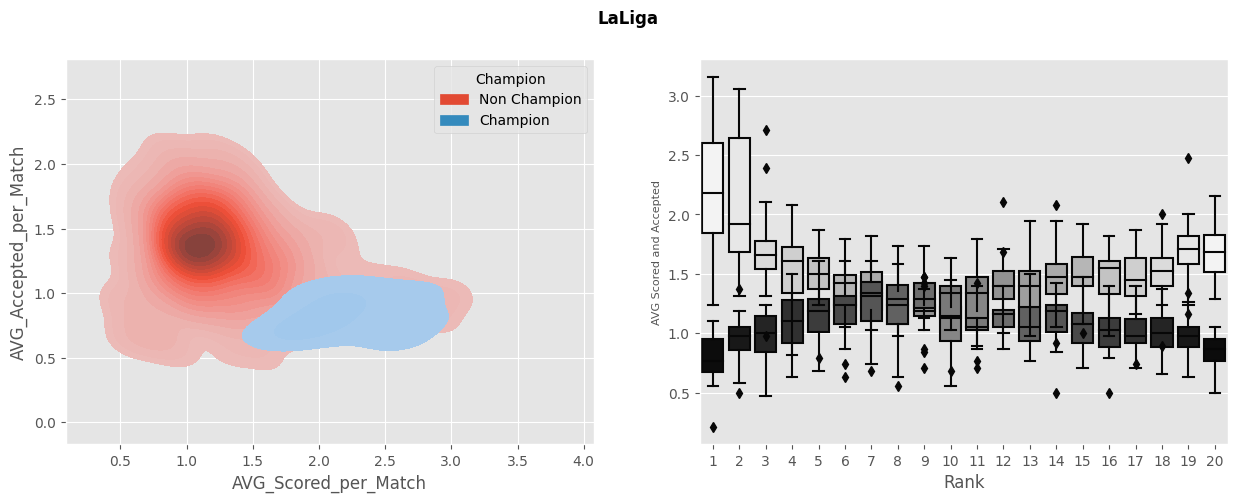

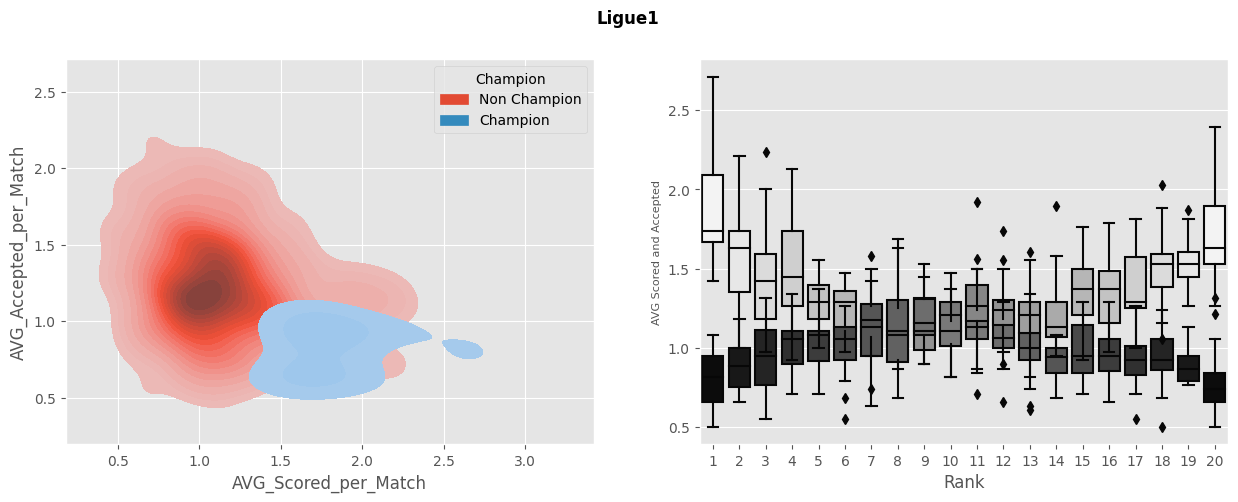

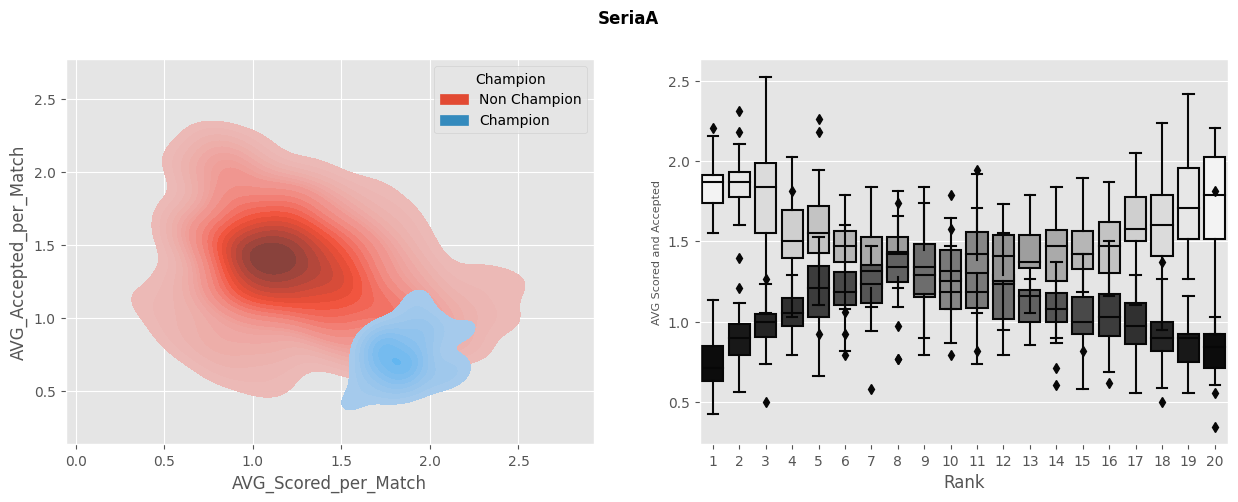

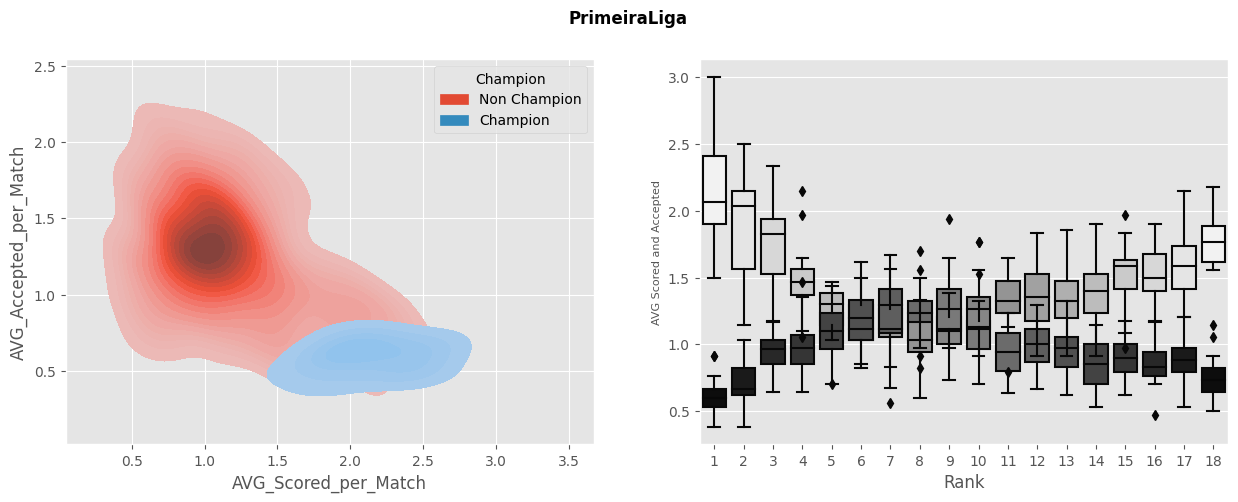

In [30]:
for league in merged_ss_gk['League'].unique():
    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
    filt=merged_ss_gk.query('League==@league')
    
    sns.kdeplot(filt,x='AVG_Scored_per_Match',y='AVG_Accepted_per_Match',hue='Champion',levels=20,shade=True,ax=ax1)
    
    #sns.lineplot(filt,x='Rank',y='AVG_Scored_per_Match',ci=100,ax=ax2,label='Scored',color='grey')
    #sns.lineplot(filt,x='Rank',y='AVG_Accepted_per_Match',ci=100,ax=ax2,label='Accepted',color='black')
    sns.boxplot(filt,x='Rank',y='AVG_Scored_per_Match',palette='binary')
    sns.boxplot(filt,x='Rank',y='AVG_Accepted_per_Match',palette='gray')
    ax2.set_ylabel('AVG Scored and Accepted',size=8)
    
    ax2.set_xticks(filt['Rank'].unique()-1,filt['Rank'].unique())
    plt.suptitle(league,fontweight='bold')
    plt.show()
    
print('\n\n\n\n')